In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
from utils import sliding_correlation

In [2]:
load_dotenv()
dataset_path = os.getenv("DATASET_PATH")
instruments = os.getenv("INSTRUMENTS").split(",")

In [3]:
with open(os.path.join(dataset_path, "dataset_metadata.json"), "r") as f:
    dataset_metadata = json.load(f)

In [4]:
for artist, songs in list(dataset_metadata.items()):
    for song in list(songs.keys()):
        if (
            dataset_metadata[artist][song]["layout"] is None
            or None in dataset_metadata[artist][song]["layout"]
        ):
            print(f"Removing {artist} - {song}: invalid layout")
            del dataset_metadata[artist][song]
            continue
        if sorted(dataset_metadata[artist][song]["layout"]) != sorted(
            instruments
        ):
            print(f"Removing {artist} - {song}: instrument mismatch")
            del dataset_metadata[artist][song]

    if len(dataset_metadata[artist]) == 0:
        del dataset_metadata[artist]

Removing Abhishek Ravi Shankar - Brindavanam Idhuvo: instrument mismatch
Removing Abhishek Ravi Shankar - Kamakshi Varlakshmi: instrument mismatch
Removing Abhishek Ravi Shankar - Manasa Etulo: instrument mismatch
Removing Abhishek Ravi Shankar - Palaya Sada: instrument mismatch
Removing Abhishek Ravi Shankar - Sami Ninne: instrument mismatch
Removing Abhishek Ravi Shankar - Tappagane Vachunna: invalid layout
Removing Aditya Narayanan - Chittam Irangadhe: instrument mismatch
Removing Aditya Narayanan - Koluvamaragada: instrument mismatch
Removing Aditya Narayanan - Sarasaksha Palaya: instrument mismatch
Removing Ameya Karthikeyan - iniyagilum ninai: invalid layout
Removing Brinda Manickavasagan - Bhavanuta: invalid layout
Removing Brinda Manickavasagan - Muripemu: instrument mismatch
Removing Brinda Manickavasagan - Ranganayakam: instrument mismatch
Removing Brinda Manickavasagan - Satre Vilagi: instrument mismatch
Removing Brinda Manickavasagan - Valapu Thala: instrument mismatch
Remo

In [5]:
print(f"number of artists after filtering: {len(dataset_metadata)}")
print(
    f"number of songs after filtering: {sum(len(songs) for songs in dataset_metadata.values())}"
)

number of artists after filtering: 26
number of songs after filtering: 161


In [6]:
vocal_motion_features = {}
motion_features = {}
audio_features = {}

for artist, songs in tqdm(dataset_metadata.items(), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    vocal_motion_features.setdefault(artist, {})
    motion_features.setdefault(artist, {})
    audio_features.setdefault(artist, {})

    for song in tqdm(songs, desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        vocal_motion_features[artist].setdefault(song, {})
        motion_features[artist].setdefault(song, {})
        audio_features[artist].setdefault(song, {})

        instrument_dir = os.path.join(song_dir, "vocal")
        if not os.path.exists(instrument_dir):
            continue

        try:
            with open(
                os.path.join(instrument_dir, "motion_features.json"), "r"
            ) as f:
                motion_features[artist][song] = json.load(f)
            with open(
                os.path.join(instrument_dir, "vocal_motion_features.json"), "r"
            ) as f:
                vocal_motion_features[artist][song] = json.load(f)
            with open(
                os.path.join(instrument_dir, "audio_features.json"), "r"
            ) as f:
                audio_features[artist][song] = json.load(f)
        except FileNotFoundError:
            print(f"File not found for {artist}/{song}.")
            continue

Artists:  19%|█▉        | 5/26 [00:08<00:37,  1.78s/it]

File not found for Ashok Subramaniaym/Arunachala Ramana.
File not found for Ashok Subramaniaym/Emouma VInavi.


File not found for Ashok Subramaniaym/Peiyaval Kaan.
File not found for Ashok Subramaniaym/Raa raa.
File not found for Ashok Subramaniaym/Sharavana Bhava.


Artists:  23%|██▎       | 6/26 [00:10<00:33,  1.66s/it]

File not found for Ashwin Srikanth/Nekkurugi.


Artists:  31%|███       | 8/26 [00:12<00:26,  1.47s/it]

File not found for Hamzini/Chandra Chooda.


Artists:  35%|███▍      | 9/26 [00:13<00:20,  1.19s/it]

File not found for Hamzini/Paradevata.
File not found for Hamzini/Thillana.


Artists:  50%|█████     | 13/26 [00:18<00:17,  1.34s/it]

File not found for Raghav Krishna/Nava Loka Nayike.


Artists:  62%|██████▏   | 16/26 [00:22<00:13,  1.37s/it]

File not found for Sampadgodu Vighnaraja/Endhuku Nirdhaya.


Artists:  69%|██████▉   | 18/26 [00:25<00:10,  1.31s/it]

File not found for Shradda Ganesh/Sangeetha Gnanamu.


Artists:  77%|███████▋  | 20/26 [00:27<00:06,  1.16s/it]

File not found for Shruthi Bhat/Sri Rama Ika Nannu.


Artists:  81%|████████  | 21/26 [00:28<00:06,  1.21s/it]

File not found for Srividya Vadnamali/Entha Modi.


Artists: 100%|██████████| 26/26 [00:36<00:00,  1.40s/it]


## Case study

In [7]:
artist = "Ameya Karthikeyan"
song = "Jalajakshi"

In [8]:
# Motion features we want to analyze
motion_features_to_analyze = ["mouth_area", "jaw_to_nose"]

# Initialize results dictionary
vocal_strong_windows = {artist: {song: {}}}

fps = 30
window_size = int(0.5 * fps)  # 0.5 second windows
step_size = int(0.1 * fps)  # 0.1 second steps

print(f"Analyzing {artist} - {song}")
print(f"Window size: {window_size} frames ({window_size/fps:.1f}s)")
print(f"Step size: {step_size} frames ({step_size/fps:.1f}s)")

# Get the audio features
audio_onset_env = audio_features[artist][song]["onset_env"]
audio_rms = audio_features[artist][song]["rms"]

for motion_feature in motion_features_to_analyze:
    if motion_feature not in vocal_strong_windows[artist][song]:
        vocal_strong_windows[artist][song][motion_feature] = {}

    print(f"\nAnalyzing {motion_feature}...")

    # Get the motion feature data
    motion_data = vocal_motion_features[artist][song][motion_feature]

    # Compute sliding correlation with onset_env
    correlations_onset, times_onset, strong_correlation_windows_onset = (
        sliding_correlation(
            motion_data,
            audio_onset_env,
            window_size,
            step_size,
            fps,
            threshold=0.5,  # Strong correlation threshold
        )
    )

    # Compute sliding correlation with rms
    correlations_rms, times_rms, strong_correlation_windows_rms = (
        sliding_correlation(
            motion_data,
            audio_rms,
            window_size,
            step_size,
            fps,
            threshold=0.5,  # Strong correlation threshold
        )
    )

    # Store results
    vocal_strong_windows[artist][song][motion_feature] = {
        "correlations_onset": correlations_onset.tolist(),
        "times_onset": times_onset.tolist(),
        "strong_windows_onset": strong_correlation_windows_onset,
        "num_strong_windows_onset": len(strong_correlation_windows_onset),
        "correlations_rms": correlations_rms.tolist(),
        "times_rms": times_rms.tolist(),
        "strong_windows_rms": strong_correlation_windows_rms,
        "num_strong_windows_rms": len(strong_correlation_windows_rms),
    }

    print(
        f"Found {len(strong_correlation_windows_onset)} strong correlation windows for {motion_feature} (onset_env)"
    )
    if strong_correlation_windows_onset:
        print("Strong correlation periods (onset_env):")
        for time, corr in strong_correlation_windows_onset:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

    print(
        f"Found {len(strong_correlation_windows_rms)} strong correlation windows for {motion_feature} (rms)"
    )
    if strong_correlation_windows_rms:
        print("Strong correlation periods (rms):")
        for time, corr in strong_correlation_windows_rms:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

Analyzing Ameya Karthikeyan - Jalajakshi
Window size: 15 frames (0.5s)
Step size: 3 frames (0.1s)

Analyzing mouth_area...
Found 25 strong correlation windows for mouth_area (onset_env)
Strong correlation periods (onset_env):
  Time: 3.40s, Correlation: -0.561
  Time: 4.20s, Correlation: -0.517
  Time: 9.90s, Correlation: -0.645
  Time: 12.70s, Correlation: -0.540
  Time: 12.80s, Correlation: -0.545
  Time: 12.90s, Correlation: -0.558
  Time: 13.00s, Correlation: -0.562
  Time: 13.10s, Correlation: -0.654
  Time: 19.10s, Correlation: -0.621
  Time: 19.50s, Correlation: -0.781
  Time: 21.40s, Correlation: 0.739
  Time: 21.50s, Correlation: 0.632
  Time: 21.60s, Correlation: 0.747
  Time: 21.70s, Correlation: 0.759
  Time: 23.30s, Correlation: 0.529
  Time: 24.70s, Correlation: -0.666
  Time: 24.80s, Correlation: -0.587
  Time: 24.90s, Correlation: -0.567
  Time: 26.00s, Correlation: 0.646
  Time: 26.20s, Correlation: 0.522
  Time: 27.20s, Correlation: 0.524
  Time: 29.50s, Correlation: 


CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS

{motion_feature.upper()} COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: -0.005
    Max correlation: 1.000
    Strong correlation windows: 25
    % of time with strong correlation: 6.2%
  RMS ENERGY:
    Mean correlation: 0.124
    Max correlation: 1.000
    Strong correlation windows: 102
    % of time with strong correlation: 25.2%
  → RMS energy shows better correlation (25.2% vs 6.2%)

{motion_feature.upper()} COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: 0.011
    Max correlation: 1.000
    Strong correlation windows: 23
    % of time with strong correlation: 5.7%
  RMS ENERGY:
    Mean correlation: 0.184
    Max correlation: 1.000
    Strong correlation windows: 107
    % of time with strong correlation: 26.5%
  → RMS energy shows better correlation (26.5% vs 5.7%)


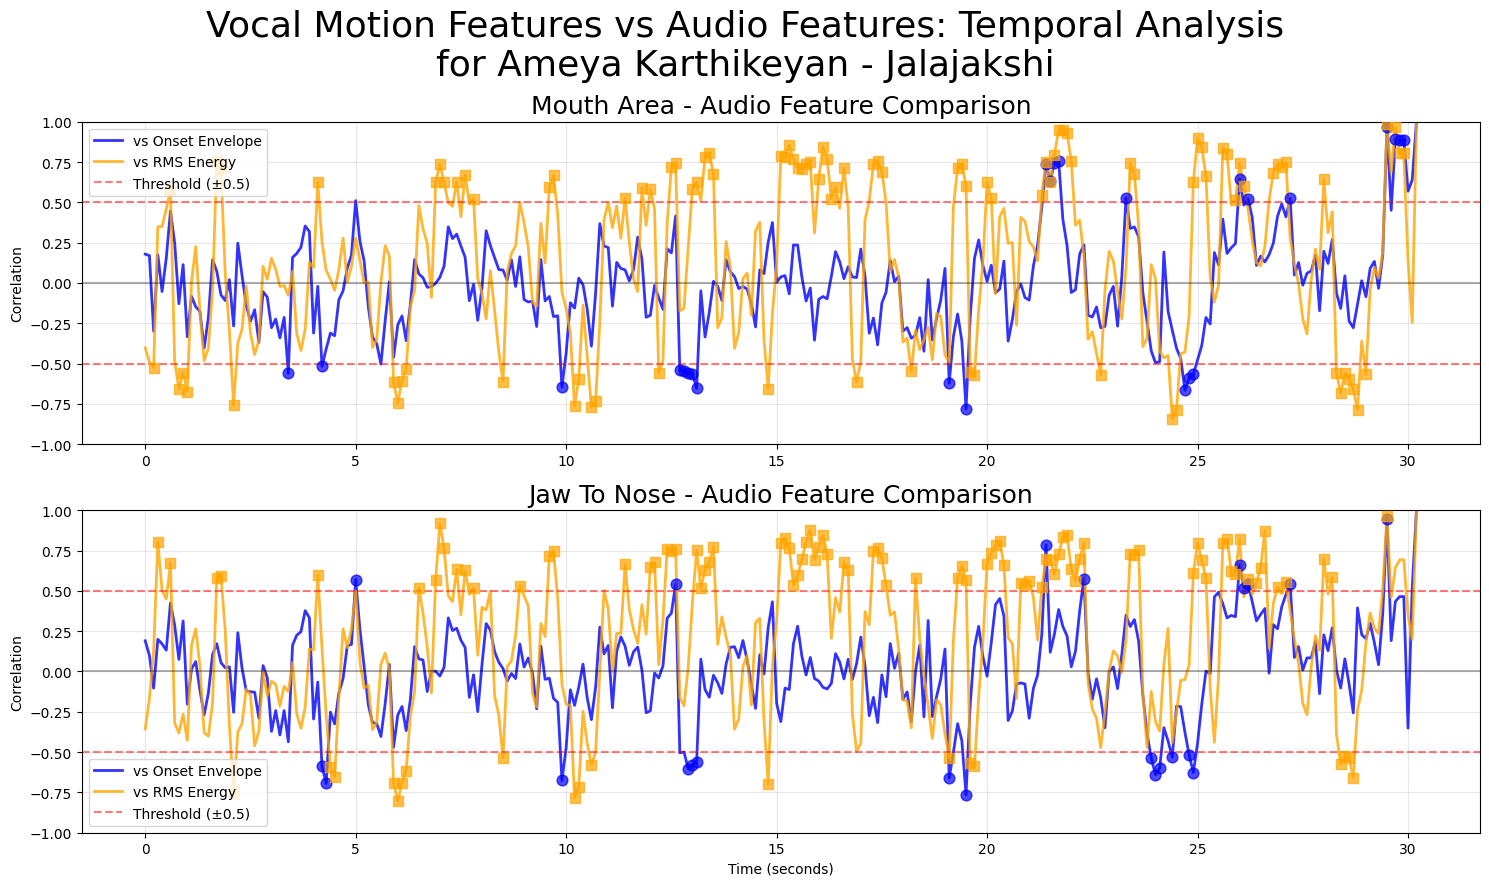


OVERALL AUDIO FEATURE COMPARISON SUMMARY
Total strong correlation windows:
  Onset Envelope: 48
  RMS Energy: 209

✓ RMS Energy overall shows better correlation with vocal motion features!


In [ ]:
# Summary and visualization of results with onset env and RMS overlay

print("\n" + "=" * 60)
print("CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS")
print("=" * 60)

fig, axes = plt.subplots(2, 1, figsize=(15, 9))
fig.suptitle(
    f"Vocal Motion Features vs Audio Features: Temporal Analysis\nfor {artist} - {song}",
    fontsize=26,
)

for i, motion_feature in enumerate(motion_features_to_analyze):
    results = vocal_strong_windows[artist][song][motion_feature]

    ax = axes[i]

    # Plot both onset and RMS correlations
    ax.plot(
        results["times_onset"],
        results["correlations_onset"],
        alpha=0.8,
        linewidth=2,
        color="blue",
        label="vs Onset Envelope",
    )
    ax.plot(
        results["times_rms"],
        results["correlations_rms"],
        alpha=0.8,
        linewidth=2,
        color="orange",
        label="vs RMS Energy",
    )

    # Threshold lines
    ax.axhline(
        y=0.5, color="r", linestyle="--", alpha=0.5, label="Threshold (±0.5)"
    )
    ax.axhline(y=-0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Mark strong correlation windows with different markers
    for time, corr in results["strong_windows_onset"]:
        ax.scatter(
            time, corr, color="blue", s=60, zorder=5, marker="o", alpha=0.7
        )

    for time, corr in results["strong_windows_rms"]:
        ax.scatter(
            time, corr, color="orange", s=60, zorder=5, marker="s", alpha=0.7
        )

    ax.set_title(
        f'{motion_feature.replace("_", " ").title()} - Audio Feature Comparison',
        fontsize=18,
    )
    if i == 1:
        ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Correlation")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(-1, 1)

    # Print summary statistics for both audio features
    correlations_onset = np.array(results["correlations_onset"])
    correlations_rms = np.array(results["correlations_rms"])

    print("\n{motion_feature.upper()} COMPARISON:")
    print("  ONSET ENVELOPE:")
    print(f"    Mean correlation: {np.nanmean(correlations_onset):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_onset):.3f}")
    print(
        f"    Strong correlation windows: {results['num_strong_windows_onset']}"
    )
    print(
        f"    % of time with strong correlation: {results['num_strong_windows_onset'] / len(correlations_onset) * 100:.1f}%"
    )

    print("  RMS ENERGY:")
    print(f"    Mean correlation: {np.nanmean(correlations_rms):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_rms):.3f}")
    print(
        f"    Strong correlation windows: {results['num_strong_windows_rms']}"
    )
    print(
        f"    % of time with strong correlation: {results['num_strong_windows_rms'] / len(correlations_rms) * 100:.1f}%"
    )

    # Determine which audio feature correlates better
    onset_pct = (
        results["num_strong_windows_onset"] / len(correlations_onset) * 100
    )
    rms_pct = results["num_strong_windows_rms"] / len(correlations_rms) * 100

    if rms_pct > onset_pct:
        print(
            f"  → RMS energy shows better correlation ({rms_pct:.1f}% vs {onset_pct:.1f}%)"
        )
    else:
        print(
            f"  → Onset envelope shows better correlation ({onset_pct:.1f}% vs {rms_pct:.1f}%)"
        )

plt.tight_layout()
plt.show()

# Overall comparison summary
print(f"\n{'='*60}")
print("OVERALL AUDIO FEATURE COMPARISON SUMMARY")
print(f"{'='*60}")

total_onset_windows = sum(
    vocal_strong_windows[artist][song][feat]["num_strong_windows_onset"]
    for feat in motion_features_to_analyze
)
total_rms_windows = sum(
    vocal_strong_windows[artist][song][feat]["num_strong_windows_rms"]
    for feat in motion_features_to_analyze
)

print("Total strong correlation windows:")
print(f"  Onset Envelope: {total_onset_windows}")
print(f"  RMS Energy: {total_rms_windows}")

if total_rms_windows > total_onset_windows:
    print(
        "\n✓ RMS Energy overall shows better correlation with vocal motion features!"
    )
else:
    print(
        "\n✓ Onset Envelope overall shows better correlation with vocal motion features!"
    )


COMPARISON: GENERAL vs VOCAL-SPECIFIC MOTION FEATURES
Total frames: 1225 | Valid (no NaNs in vocal features): 899 | Removed: 326


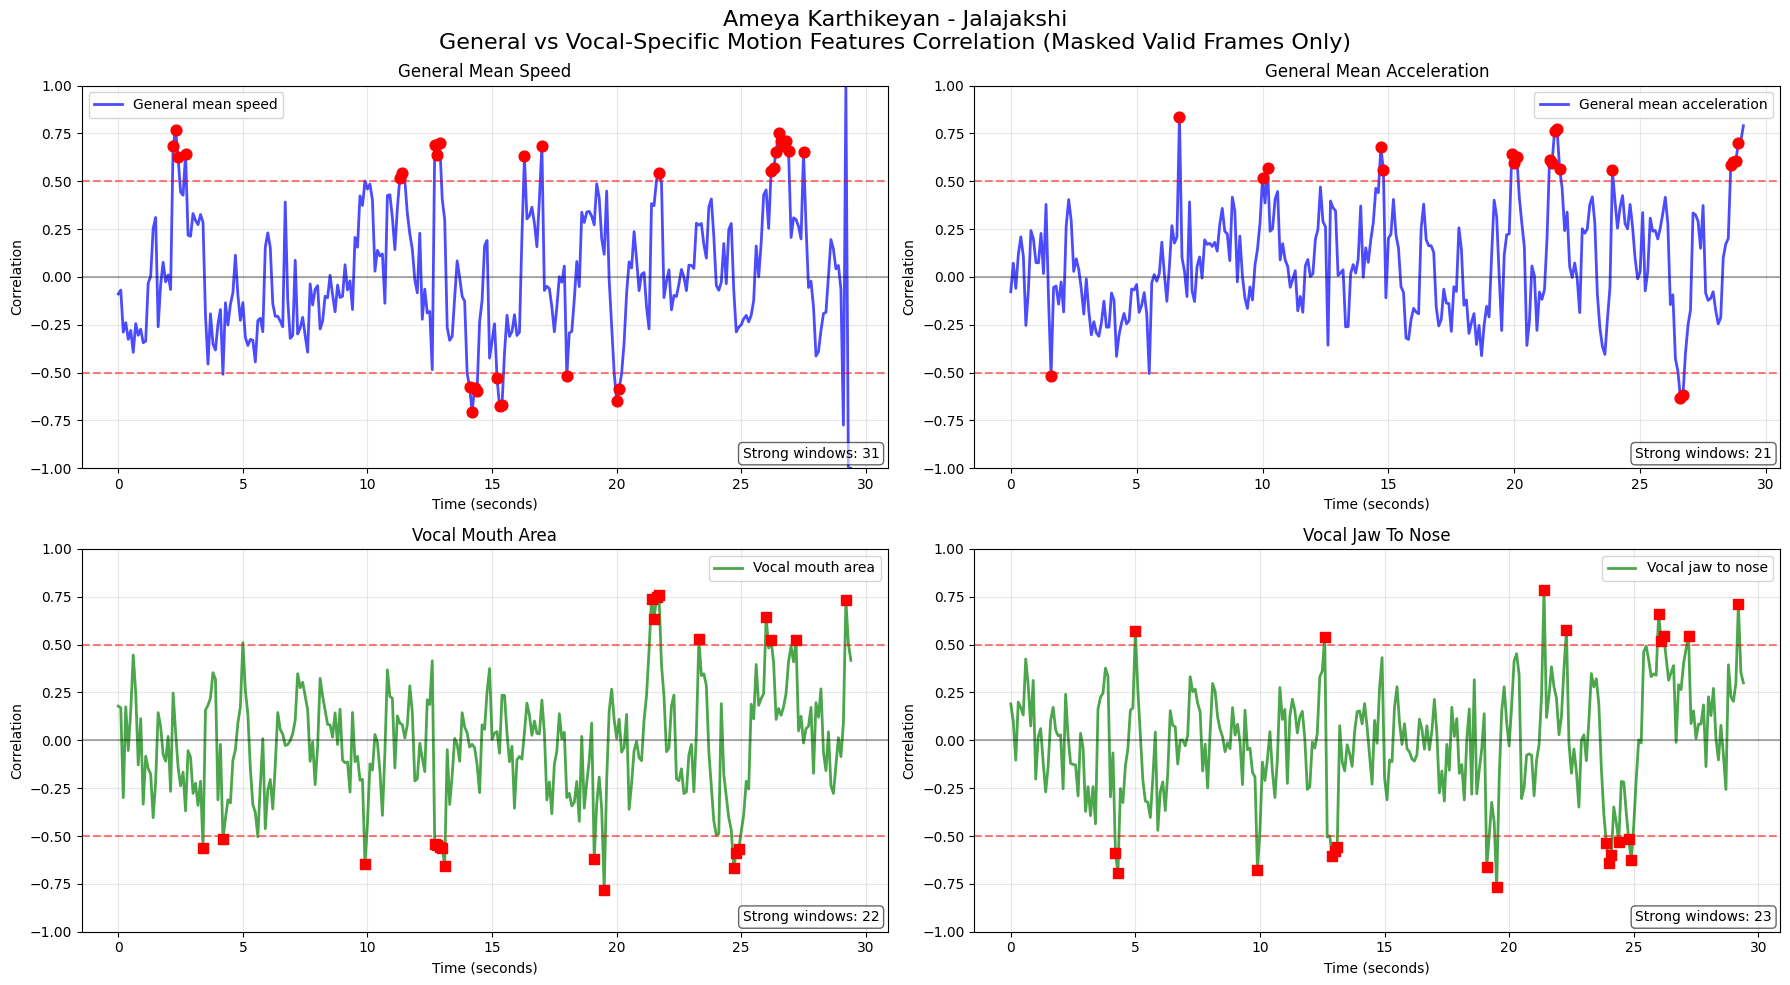

In [10]:
# Comparison analysis: General vs vocal-specific motion features
print("\n" + "=" * 80)
print("COMPARISON: GENERAL vs VOCAL-SPECIFIC MOTION FEATURES")
print("=" * 80)

# Create a valid-frame mask based on vocal motion features (exclude any frame with NaN in any vocal feature)
vocal_features_stack = np.column_stack(
    [
        np.array(vocal_motion_features[artist][song][f])
        for f in motion_features_to_analyze
    ]
)
valid_mask = ~np.any(np.isnan(vocal_features_stack), axis=1)
num_total = vocal_features_stack.shape[0]
num_valid = int(valid_mask.sum())
print(
    f"Total frames: {num_total} | Valid (no NaNs in vocal features): {num_valid} | Removed: {num_total - num_valid}"
)

# Mask audio feature arrays to keep alignment
audio_onset_env_masked = np.array(audio_onset_env)[valid_mask]
# If needed later, mask other audio features similarly (e.g., RMS)

# General motion features to compare (ensure they have been loaded into motion_features['general'])
general_features = ["mean_speed", "mean_acceleration"]

# Sanity check lengths
for gf in general_features:
    if len(motion_features[artist][song]["general"][gf]) != num_total:
        raise ValueError(
            f"Length mismatch for general feature {gf}: expected {num_total}, got {len(motion_features[artist][song]['general'][gf])}"
        )

if len(audio_onset_env_masked) < window_size:
    raise ValueError(
        "Not enough valid frames after masking to perform sliding correlation. Consider reducing window_size or investigating masking."
    )

# Create comparison data structure
comparison_data = {}


# Helper to run sliding correlation safely with masked data
def masked_sliding_correlation(motion_array, audio_array):
    if len(motion_array) != len(audio_array):
        raise ValueError("Masked arrays must have the same length")
    if len(motion_array) < window_size:
        return np.array([]), np.array([]), []
    return sliding_correlation(
        motion_array,
        audio_array,
        window_size,
        step_size,
        fps,
        threshold=0.5,
    )


# Add general motion features data (apply mask)
for feature in general_features:
    motion_data = np.array(motion_features[artist][song]["general"][feature])[
        valid_mask
    ]
    correlations, times, strong_windows_list = masked_sliding_correlation(
        motion_data, audio_onset_env_masked
    )
    comparison_data[f"general_{feature}"] = {
        "correlations": correlations,
        "times": times,
        "strong_windows": strong_windows_list,
        "type": "general",
    }

# Add vocal-specific motion features data (apply same mask)
for feature in motion_features_to_analyze:
    motion_data = np.array(vocal_motion_features[artist][song][feature])[
        valid_mask
    ]
    correlations, times, strong_windows_list = masked_sliding_correlation(
        motion_data, audio_onset_env_masked
    )
    comparison_data[f"vocal_{feature}"] = {
        "correlations": correlations,
        "times": times,
        "strong_windows": strong_windows_list,
        "type": "vocal",
    }

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle(
    f"{artist} - {song}\nGeneral vs Vocal-Specific Motion Features Correlation (Masked Valid Frames Only)",
    fontsize=16,
)

# Plot general features in top row
for i, feature in enumerate(general_features):
    ax = axes[0, i]
    data = comparison_data[f"general_{feature}"]

    ax.plot(
        data["times"],
        data["correlations"],
        alpha=0.7,
        linewidth=2,
        color="blue",
        label=f'General {feature.replace("_", " ")}',
    )
    ax.axhline(y=0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=-0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Mark strong correlation windows
    for time, corr in data["strong_windows"]:
        ax.scatter(time, corr, color="red", s=60, zorder=5, marker="o")

    ax.set_title(f'General {feature.replace("_", " ").title()}')
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Correlation")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)
    # Annotate number of strong windows
    ax.text(
        0.99,
        0.02,
        f"Strong windows: {len(data['strong_windows'])}",
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6),
    )
    ax.legend()

# Plot vocal features in bottom row
for i, feature in enumerate(motion_features_to_analyze):
    ax = axes[1, i]
    data = comparison_data[f"vocal_{feature}"]

    ax.plot(
        data["times"],
        data["correlations"],
        alpha=0.7,
        linewidth=2,
        color="green",
        label=f'Vocal {feature.replace("_", " ")}',
    )
    ax.axhline(y=0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=-0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Mark strong correlation windows
    for time, corr in data["strong_windows"]:
        ax.scatter(time, corr, color="red", s=60, zorder=5, marker="s")

    ax.set_title(f'Vocal {feature.replace("_", " ").title()}')
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Correlation")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)
    # Annotate number of strong windows
    ax.text(
        0.99,
        0.02,
        f"Strong windows: {len(data['strong_windows'])}",
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6),
    )
    ax.legend()

plt.tight_layout()
plt.show()

## Global study

In [11]:
vocal_features_list = motion_features_to_analyze
general_features_list = ["mean_speed", "mean_acceleration"]
audio_features_list = ["onset_env", "rms"]
threshold = 0.5
p_value_alpha = 0.05

group_counts = {
    grp: {
        mfeat: {afeat: 0 for afeat in audio_features_list}
        for mfeat in (
            vocal_features_list if grp == "vocal" else general_features_list
        )
    }
    for grp in ["vocal", "general"]
}

group_total_windows = {
    grp: {
        mfeat: {afeat: 0 for afeat in audio_features_list}
        for mfeat in (
            vocal_features_list if grp == "vocal" else general_features_list
        )
    }
    for grp in ["vocal", "general"]
}

per_song_results = {}

print("\n" + "=" * 90)
print(
    "GLOBAL COMPARISON: vocal-Specific vs General Motion Features vs Audio (onset_env & rms)"
)
print("(Reusing preloaded feature dictionaries; no disk I/O in this cell)")
print("Threshold: |r| > %.2f and p < 0.05" % threshold)
print("=" * 90)

num_songs_processed = 0
num_songs_skipped_short = 0
num_songs_skipped_missing = 0

for artist, songs in vocal_motion_features.items():
    for song, v_feats in songs.items():
        if artist not in audio_features or song not in audio_features[artist]:
            num_songs_skipped_missing += 1
            continue
        if (
            artist not in motion_features
            or song not in motion_features[artist]
        ):
            num_songs_skipped_missing += 1
            continue
        m_feats = motion_features[artist][song]
        a_feats = audio_features[artist][song]
        if "general" not in m_feats:
            num_songs_skipped_missing += 1
            continue
        if not all(af in a_feats for af in audio_features_list):
            num_songs_skipped_missing += 1
            continue

        try:
            vocal_arrays = [
                np.asarray(v_feats[feat], dtype=float)
                for feat in vocal_features_list
            ]
            general_arrays = [
                np.asarray(m_feats["general"][feat], dtype=float)
                for feat in general_features_list
            ]
        except KeyError:
            num_songs_skipped_missing += 1
            continue

        lengths = {arr.shape[0] for arr in vocal_arrays + general_arrays}
        if len(lengths) != 1:
            print(f"Length mismatch for {artist}/{song}; skipping.")
            num_songs_skipped_missing += 1
            continue
        num_frames = lengths.pop()

        audio_arrays = {
            afeat: np.asarray(a_feats[afeat], dtype=float)
            for afeat in audio_features_list
        }
        if any(arr.shape[0] != num_frames for arr in audio_arrays.values()):
            print(f"Audio length mismatch for {artist}/{song}; skipping.")
            num_songs_skipped_missing += 1
            continue

        feature_stack = np.column_stack(vocal_arrays + general_arrays)
        valid_mask = ~np.any(np.isnan(feature_stack), axis=1)
        if valid_mask.sum() < window_size:
            num_songs_skipped_short += 1
            continue

        masked_vocal_arrays = [arr[valid_mask] for arr in vocal_arrays]
        masked_general_arrays = [arr[valid_mask] for arr in general_arrays]
        masked_audio_arrays = {
            afeat: arr[valid_mask] for afeat, arr in audio_arrays.items()
        }

        song_result = {
            "vocal": {},
            "general": {},
            "num_valid_frames": int(valid_mask.sum()),
        }

        def process_feature(feat_name, data_array, group):
            song_result[group].setdefault(feat_name, {})
            for afeat, audio_arr in masked_audio_arrays.items():
                correlations, times, strong_windows = sliding_correlation(
                    data_array,
                    audio_arr,
                    window_size,
                    step_size,
                    fps,
                    threshold=threshold,
                )
                group_counts[group][feat_name][afeat] += len(strong_windows)
                group_total_windows[group][feat_name][
                    afeat
                ] += correlations.shape[0]
                song_result[group][feat_name][afeat] = {
                    "num_strong_windows": len(strong_windows),
                    "total_windows": int(correlations.shape[0]),
                    "strong_windows": strong_windows,  # list of (time, corr)
                }

        # vocal motion features
        for feat_name, arr in zip(vocal_features_list, masked_vocal_arrays):
            process_feature(feat_name, arr, "vocal")
        # General motion features
        for feat_name, arr in zip(
            general_features_list, masked_general_arrays
        ):
            process_feature(feat_name, arr, "general")

        per_song_results.setdefault(artist, {})[song] = song_result
        num_songs_processed += 1

print(f"Songs processed: {num_songs_processed}")
print(f"Songs skipped (missing data): {num_songs_skipped_missing}")
print(f"Songs skipped (too short after masking): {num_songs_skipped_short}")

# Aggregate summaries
print("\n" + "-" * 80)
print("AGGREGATED RESULTS (Counts of Strong Windows per Audio Feature)")
print("-" * 80)


def summarize_group(group_name):
    print(f"\n{group_name.upper()}:")
    group_totals = {afeat: 0 for afeat in audio_features_list}
    group_windows = {afeat: 0 for afeat in audio_features_list}
    for mfeat, audio_dict in group_counts[group_name].items():
        line_parts = [f"{mfeat:>20}"]
        for afeat in audio_features_list:
            strong = audio_dict[afeat]
            total_w = group_total_windows[group_name][mfeat][afeat]
            pct = (strong / total_w * 100) if total_w else 0
            line_parts.append(
                f"{afeat}: {strong:5d}/{total_w:5d} ({pct:5.1f}%)"
            )
            group_totals[afeat] += strong
            group_windows[afeat] += total_w
        print("  " + " | ".join(line_parts))
    # Overall per audio feature
    for afeat in audio_features_list:
        overall_pct = (
            (group_totals[afeat] / group_windows[afeat] * 100)
            if group_windows[afeat]
            else 0
        )
        print(
            f"    TOTAL {afeat}: {group_totals[afeat]:5d}/{group_windows[afeat]:5d} ({overall_pct:5.2f}%)"
        )
    # Combined (sum) across audio features
    combined_strong = sum(group_totals.values())
    combined_windows = sum(group_windows.values())
    combined_pct = (
        (combined_strong / combined_windows * 100) if combined_windows else 0
    )
    print(
        f"    COMBINED (sum over audio feats): {combined_strong:5d}/{combined_windows:5d} ({combined_pct:5.2f}%)"
    )
    return group_totals, group_windows


vocal_totals, vocal_windows = summarize_group("vocal")
general_totals, general_windows = summarize_group("general")

print("\nComparison (overall % strong windows per audio feature):")
for afeat in audio_features_list:
    v_pct = (
        (vocal_totals[afeat] / vocal_windows[afeat] * 100)
        if vocal_windows[afeat]
        else 0
    )
    g_pct = (
        (general_totals[afeat] / general_windows[afeat] * 100)
        if general_windows[afeat]
        else 0
    )
    if v_pct > g_pct:
        print(f"  {afeat}: vocal higher ({v_pct:.2f}% vs {g_pct:.2f}%)")
    elif g_pct > v_pct:
        print(f"  {afeat}: General higher ({g_pct:.2f}% vs {v_pct:.2f}%)")
    else:
        print(f"  {afeat}: Equal ({v_pct:.2f}%)")

# (Plotting moved to a new cell below)

# Store comprehensive results
global_results = {
    "per_song": per_song_results,
    "group_counts": group_counts,
    "group_total_windows": group_total_windows,
    "audio_features_list": audio_features_list,
    "params": {
        "threshold": threshold,
        "p_value_alpha": p_value_alpha,
        "window_size_frames": window_size,
        "step_size_frames": step_size,
        "fps": fps,
        "vocal_features": vocal_features_list,
        "general_features": general_features_list,
    },
}
print(
    "Global comparison complete (onset_env & rms). 'global_results' dict updated."
)


GLOBAL COMPARISON: vocal-Specific vs General Motion Features vs Audio (onset_env & rms)
(Reusing preloaded feature dictionaries; no disk I/O in this cell)
Threshold: |r| > 0.50 and p < 0.05
Audio length mismatch for Bhargavi Chandrasekar/Navaragamalika Varnam; skipping.
Songs processed: 131
Songs skipped (missing data): 29
Songs skipped (too short after masking): 1

--------------------------------------------------------------------------------
AGGREGATED RESULTS (Counts of Strong Windows per Audio Feature)
--------------------------------------------------------------------------------

VOCAL:
            mouth_area | onset_env: 75861/759968 ( 10.0%) | rms: 271831/759968 ( 35.8%)
           jaw_to_nose | onset_env: 76552/759968 ( 10.1%) | rms: 274919/759968 ( 36.2%)
    TOTAL onset_env: 152413/1519936 (10.03%)
    TOTAL rms: 546750/1519936 (35.97%)
    COMBINED (sum over audio feats): 699163/3039872 (23.00%)

GENERAL:
            mean_speed | onset_env: 68020/759968 (  9.0%) | rms: 

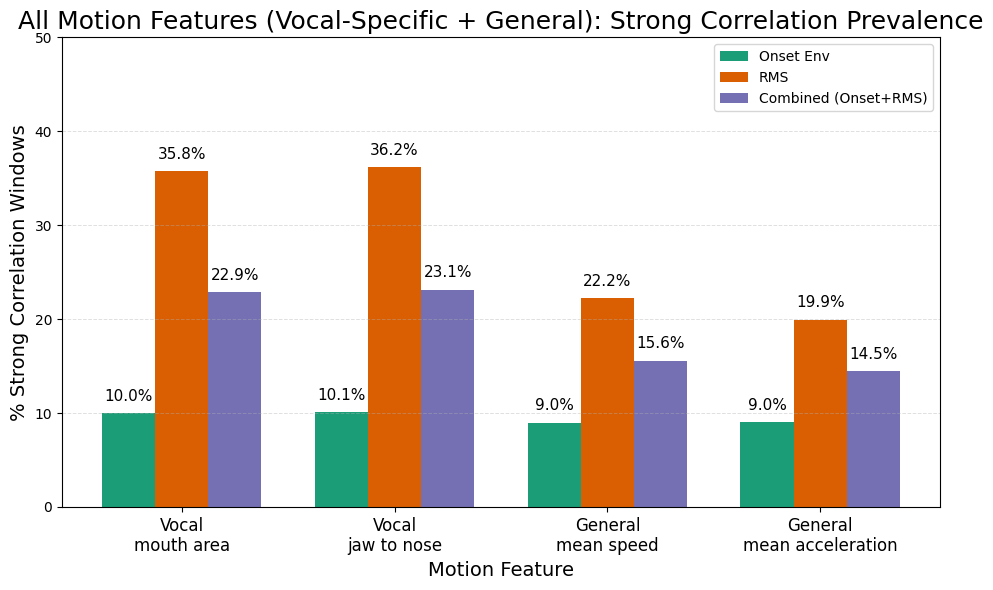

In [12]:
# Grouped bar plots: single plot with all motion features (vocal + general) each having three bars (onset, rms, combined)

if "global_results" not in globals():
    raise RuntimeError(
        "global_results not found. Run the previous cell first."
    )

# Helper to compute % strong windows for a single feature & audio feature


def compute_pct(group, motion_feat, audio_feat):
    strong = global_results["group_counts"][group][motion_feat][audio_feat]
    total = global_results["group_total_windows"][group][motion_feat][
        audio_feat
    ]
    return (strong / total * 100) if total else 0.0


# Helper to compute combined across audio features


def compute_combined_pct(group, motion_feat):
    strong_sum = sum(
        global_results["group_counts"][group][motion_feat][af]
        for af in audio_features_list
    )
    total_sum = sum(
        global_results["group_total_windows"][group][motion_feat][af]
        for af in audio_features_list
    )
    return (strong_sum / total_sum * 100) if total_sum else 0.0


# Build combined feature list: list of tuples (group, feature_name)
combined_feature_entries = [("vocal", f) for f in vocal_features_list] + [
    ("general", f) for f in general_features_list
]

n_feats = len(combined_feature_entries)
x = np.arange(n_feats)
bar_width = 0.25

onset_vals = [
    compute_pct(g, f, "onset_env") for g, f in combined_feature_entries
]
rms_vals = [compute_pct(g, f, "rms") for g, f in combined_feature_entries]
combined_vals = [
    compute_combined_pct(g, f) for g, f in combined_feature_entries
]

labels = [
    f"{g.capitalize()}\n{f.replace('_', ' ')}"
    for g, f in combined_feature_entries
]

plt.figure(figsize=(1.4 * n_feats + 4, 6))
plt.bar(
    x - bar_width,
    onset_vals,
    width=bar_width,
    color="#1b9e77",
    label="Onset Env",
)
plt.bar(x, rms_vals, width=bar_width, color="#d95f02", label="RMS")
plt.bar(
    x + bar_width,
    combined_vals,
    width=bar_width,
    color="#7570b3",
    label="Combined (Onset+RMS)",
)

plt.xticks(x, labels, fontsize=12)
plt.xlabel("Motion Feature", fontsize=14)
plt.ylabel("% Strong Correlation Windows", fontsize=14)
plt.ylim(0, 50)
plt.title(
    "All Motion Features (Vocal-Specific + General): Strong Correlation Prevalence",
    fontsize=18,
)
plt.grid(axis="y", linestyle="--", alpha=0.4, linewidth=0.7)

# Annotate
for arr, offset in [
    (onset_vals, -bar_width),
    (rms_vals, 0),
    (combined_vals, bar_width),
]:
    for xi, v in zip(x, arr):
        if v <= 50:  # annotate only within plot range
            plt.text(
                xi + offset,
                min(v + 1, 49),
                f"{v:.1f}%",
                ha="center",
                va="bottom",
                fontsize=11,
            )
        else:
            # Indicate clipped value
            plt.text(
                xi + offset,
                49,
                ">50%",
                ha="center",
                va="top",
                fontsize=8,
                color="red",
            )

plt.legend()
plt.tight_layout()
plt.show()